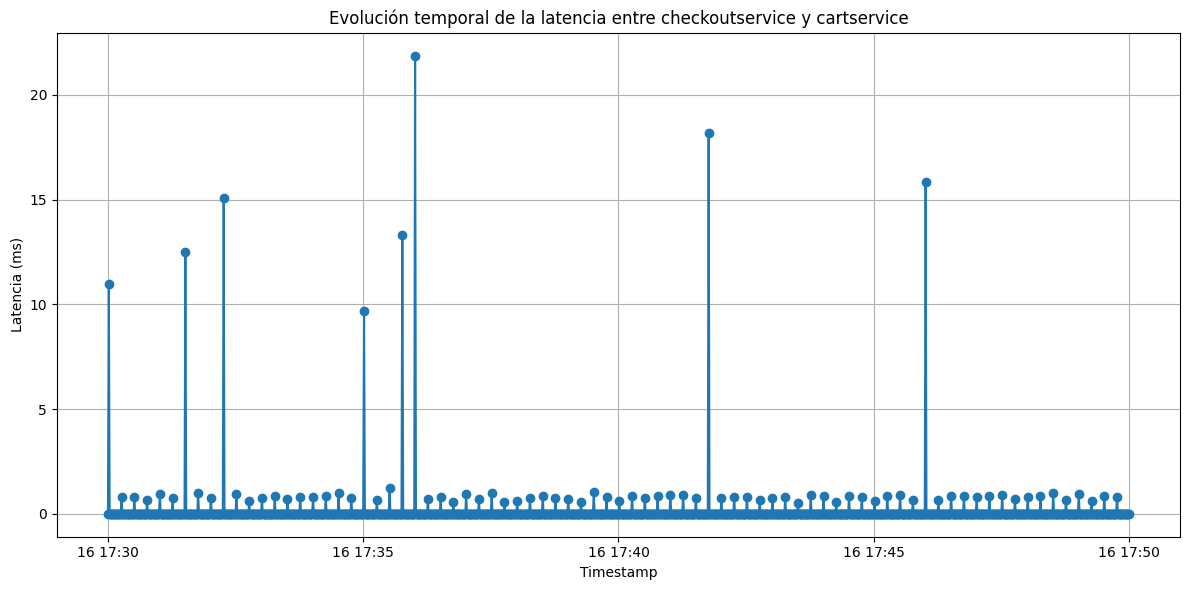

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("results/new_request_istio_data.csv", parse_dates=["timestamp"])
pair_df = df[(df["source_workload"] == "checkoutservice") & (df["destination_workload"] == "cartservice")]

plt.figure(figsize=(12,6))
plt.plot(pair_df["timestamp"], pair_df["latency"], marker='o', linestyle='-')
plt.title("Evolución temporal de la latencia entre checkoutservice y cartservice")
plt.xlabel("Timestamp")
plt.ylabel("Latencia (ms)")
plt.grid(True)
plt.tight_layout()
plt.show()


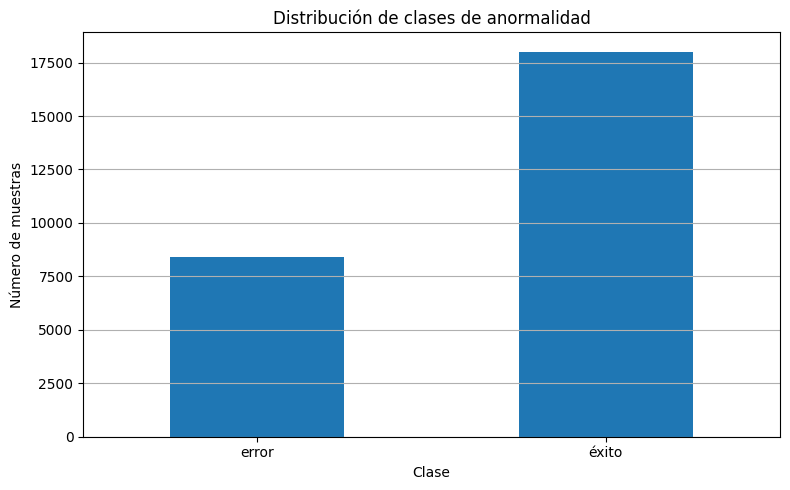

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("results/new_request_istio_data.csv")
class_counts = df["result"].value_counts().sort_index()

plt.figure(figsize=(8,5))
class_counts.plot(kind='bar')
plt.title("Distribución de clases de anormalidad")
plt.xlabel("Clase")
plt.ylabel("Número de muestras")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

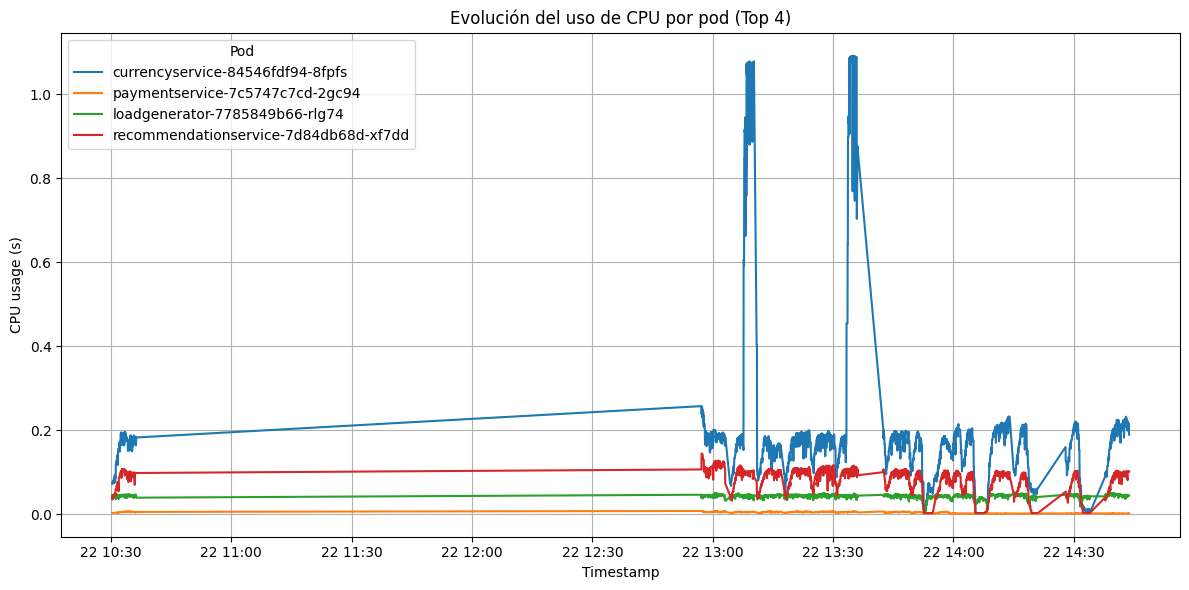

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar dataset con métricas de pods
df = pd.read_csv("results/final2_modified_sorted.csv", parse_dates=["timestamp"])

# Seleccionar pods más frecuentes
top_pods = df["pod"].value_counts().nlargest(4).index.tolist()
df_top = df[df["pod"].isin(top_pods)]

# Graficar evolución de uso de CPU para cada pod
plt.figure(figsize=(12, 6))
for pod in top_pods:
    pod_data = df_top[df_top["pod"] == pod]
    plt.plot(pod_data["timestamp"], pod_data["container_cpu_usage_seconds_total"], label=pod)

plt.title("Evolución del uso de CPU por pod (Top 4)")
plt.xlabel("Timestamp")
plt.ylabel("CPU usage (s)")
plt.legend(title="Pod")
plt.grid(True)
plt.tight_layout()
plt.show()


# Comparativa global de latencia antes y después del fallo
Este análisis muestra la distribución de la latencia media en todo el sistema antes y después de la inyección de un fallo detectado como anomalía, diferenciando entre periodos y clases (Normal/Anomalía). Se utiliza el dataset `kiali_kpi_metrics_processed.csv`.

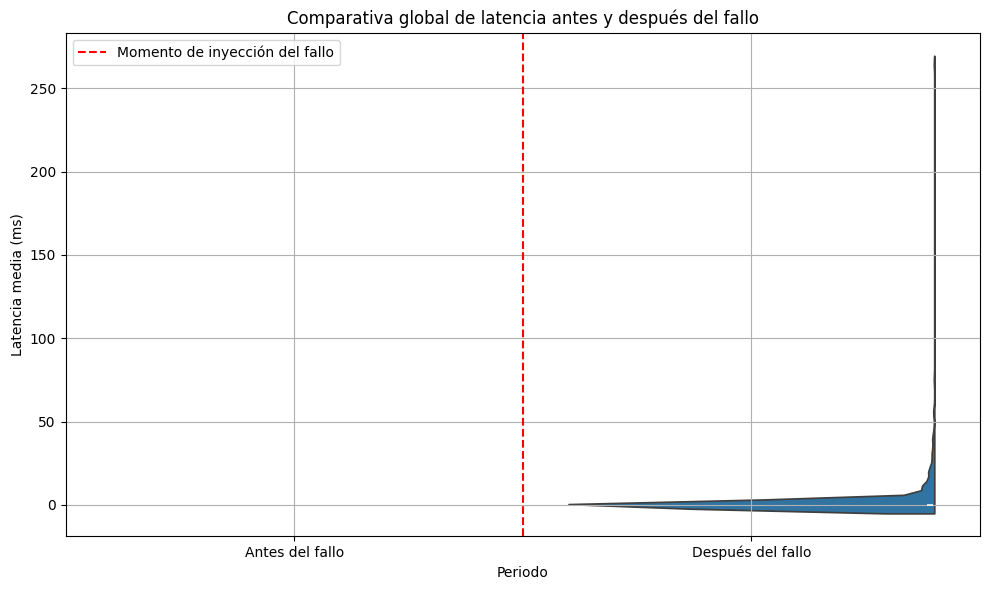

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar dataset global
kpi_df = pd.read_csv("results/kiali_kpi_metrics_processed.csv", parse_dates=["timestamp"])

# Detectar el primer timestamp de anomalía global
# (Asegura que la columna sea numérica para la comparación)
kpi_df["Abnormality class"] = pd.to_numeric(kpi_df["Abnormality class"], errors="coerce")
timestamp_fallo = kpi_df[kpi_df["Abnormality class"] != 1]["timestamp"].min()

# Definir ventanas antes y después del fallo (10 minutos)
ventana = pd.Timedelta(minutes=10)
antes_fallo = kpi_df[(kpi_df["timestamp"] >= timestamp_fallo - ventana) & (kpi_df["timestamp"] < timestamp_fallo)]
despues_fallo = kpi_df[(kpi_df["timestamp"] >= timestamp_fallo) & (kpi_df["timestamp"] < timestamp_fallo + ventana)]

# Añadir columna de periodo
antes_fallo = antes_fallo.copy()
despues_fallo = despues_fallo.copy()
antes_fallo["Periodo"] = "Antes del fallo"
despues_fallo["Periodo"] = "Después del fallo"

# Unir ambos subconjuntos
df_comparativa = pd.concat([antes_fallo, despues_fallo])

# Filtrar solo filas con latencia válida y clasificar
# (En este dataset, 1=Normal, >1=Anomalía)
df_comparativa = df_comparativa[df_comparativa["average_latency"].notna()]
df_comparativa["Clase"] = df_comparativa["Abnormality class"].apply(lambda x: "Normal" if x == 1 else "Anomalía")

# Ordenar categorías para asegurar el orden visual
orden_periodos = ["Antes del fallo", "Después del fallo"]
df_comparativa["Periodo"] = pd.Categorical(df_comparativa["Periodo"], categories=orden_periodos, ordered=True)

# Gráfico violinplot global
plt.figure(figsize=(10,6))
sns.violinplot(data=df_comparativa, x="Periodo", y="average_latency", hue="Clase", split=True, order=orden_periodos)
plt.title("Comparativa global de latencia antes y después del fallo")
plt.xlabel("Periodo")
plt.ylabel("Latencia media (ms)")
plt.grid(True)
plt.tight_layout()

# Línea roja entre periodos para indicar el fallo
plt.axvline(x=0.5, color='red', linestyle='--', label='Momento de inyección del fallo')

# Leyenda personalizada
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_elements = [
    Patch(facecolor='none', edgecolor='red', linestyle='--', label='Momento de inyección del fallo')
]
plt.legend(handles=legend_elements, loc='upper left')
# Crear una línea de leyenda en lugar de un parche
legend_line = Line2D([0], [0], color='red', linestyle='--', label='Momento de inyección del fallo')
plt.legend(handles=[legend_line], loc='upper left')
plt.show()

# Mapa de calor de latencia media entre pares de microservicios
Este gráfico muestra la latencia media observada entre cada par de microservicios (source → destination) en el sistema, usando los datos de `kiali_kpi_metrics_processed.csv`.

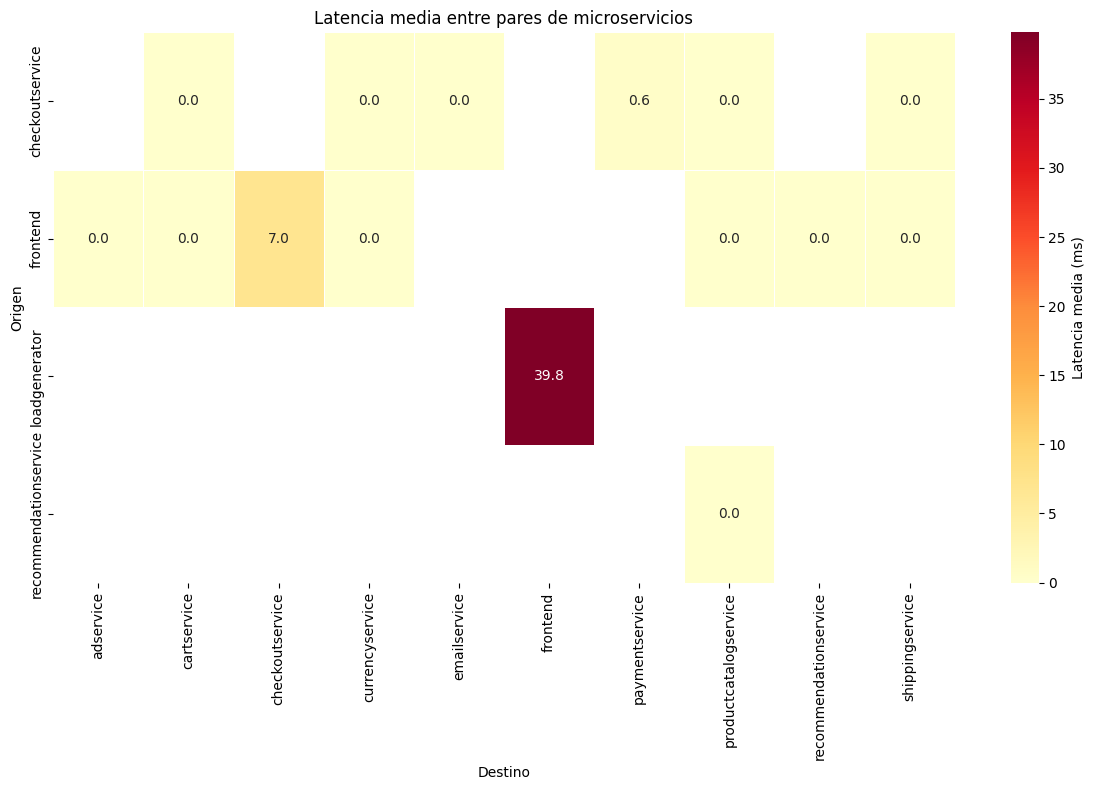

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar datos
kpi_df = pd.read_csv("results/kiali_kpi_metrics_processed.csv")

# Crear tabla pivote: filas=source, columnas=destination, valores=latencia media
heatmap_data = kpi_df.pivot_table(
    index="source_workload",
    columns="destination_workload",
    values="average_latency",
    aggfunc="mean"
)

plt.figure(figsize=(12,8))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlOrRd", linewidths=0.5, cbar_kws={'label': 'Latencia media (ms)'})
plt.title("Latencia media entre pares de microservicios")
plt.xlabel("Destino")
plt.ylabel("Origen")
plt.tight_layout()
plt.show()

# Mapa de calor de latencia media entre pares de microservicios a lo largo del tiempo
Este gráfico muestra la evolución temporal de la latencia media entre cada par de microservicios (source → destination) en el sistema, usando ventanas de tiempo.

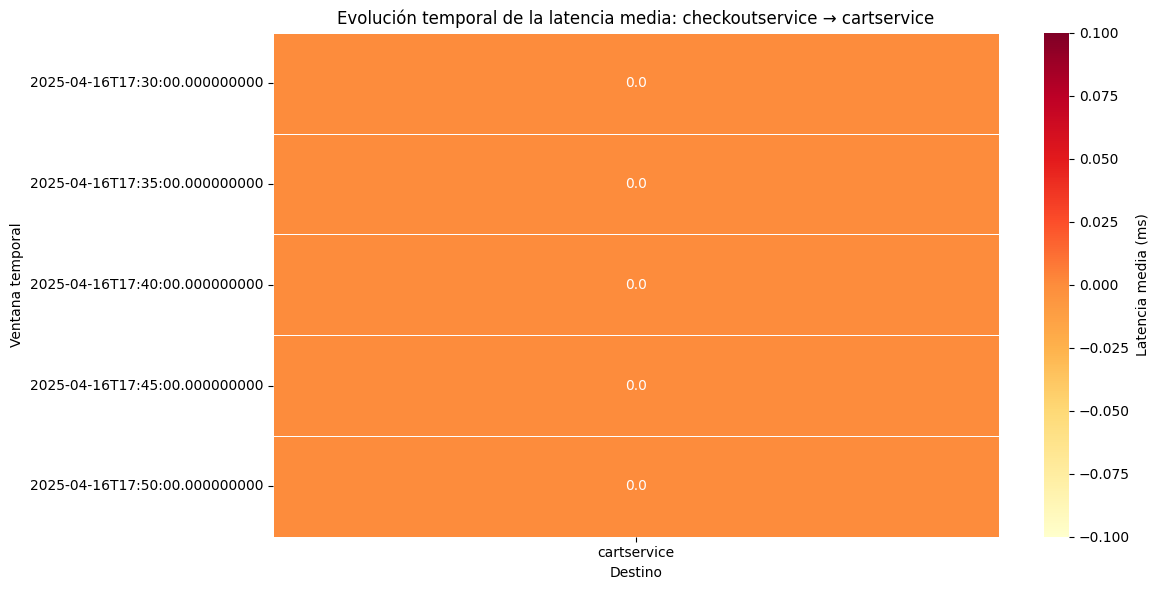

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar datos
kpi_df = pd.read_csv("results/kiali_kpi_metrics_processed.csv", parse_dates=["timestamp"])

# Elegir un par de microservicios o mostrar todos los pares (puede ser muy grande)
# Para un heatmap temporal, se recomienda filtrar por un par concreto o por los top N más frecuentes
# Aquí mostramos la evolución para el par más frecuente

# Encontrar el par más frecuente
pair_counts = kpi_df.groupby(["source_workload", "destination_workload"]).size().sort_values(ascending=False)
most_common_pair = pair_counts.index[0]

# Filtrar datos para ese par
df_pair = kpi_df[(kpi_df["source_workload"] == most_common_pair[0]) & (kpi_df["destination_workload"] == most_common_pair[1])]

# Agrupar por ventana temporal (por ejemplo, cada 5 minutos)
df_pair = df_pair.copy()
df_pair["window"] = df_pair["timestamp"].dt.floor("5min")

# Crear tabla pivote: filas=ventana temporal, columnas=par, valores=latencia media
heatmap_data = df_pair.pivot_table(
    index="window",
    columns="destination_workload",
    values="average_latency",
    aggfunc="mean"
)

plt.figure(figsize=(12,6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlOrRd", linewidths=0.5, cbar_kws={'label': 'Latencia media (ms)'})
plt.title(f"Evolución temporal de la latencia media: {most_common_pair[0]} → {most_common_pair[1]}")
plt.xlabel("Destino")
plt.ylabel("Ventana temporal")
plt.tight_layout()
plt.show()

# Mapa de calor temporal de latencia media para todos los pares de microservicios
Este gráfico muestra la evolución temporal de la latencia media para todos los pares de microservicios (source → destination) en ventanas de 5 minutos. Cada celda representa la latencia media de un par en una ventana temporal.

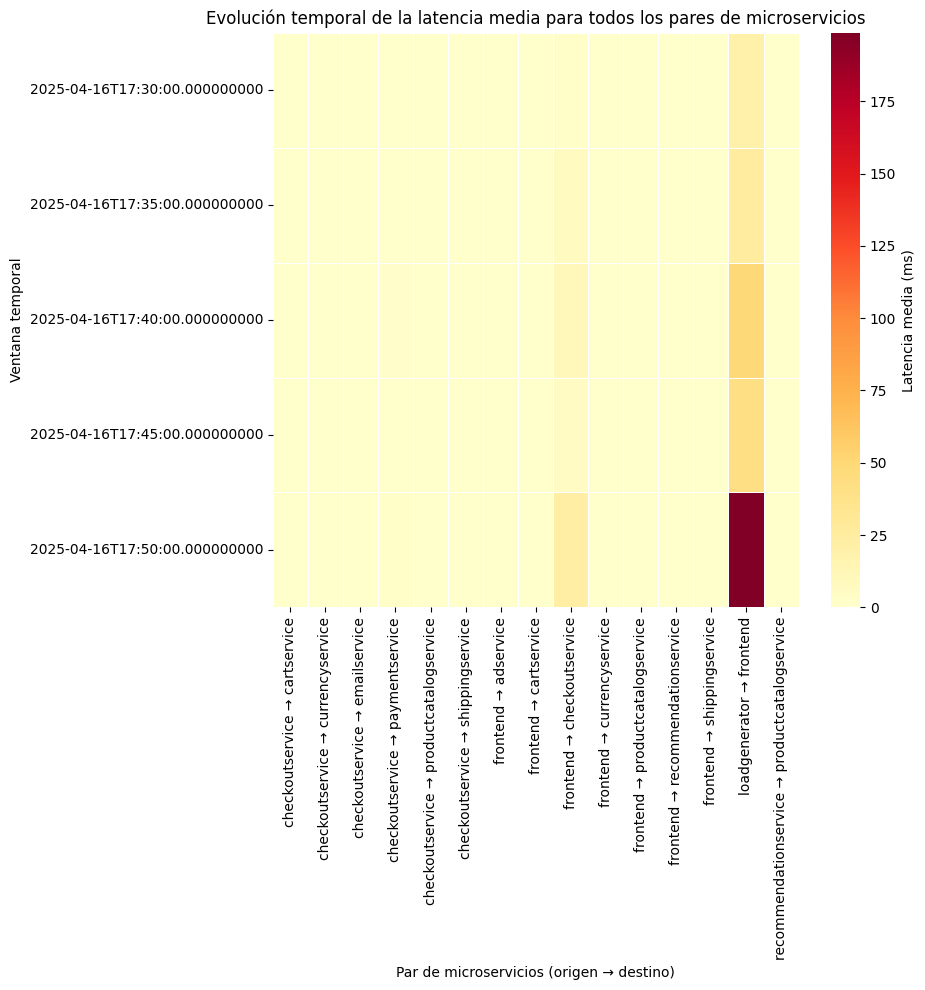

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Cargar datos
kpi_df = pd.read_csv("results/kiali_kpi_metrics_processed.csv", parse_dates=["timestamp"])

# Crear columna de ventana temporal (5 minutos)
kpi_df["window"] = kpi_df["timestamp"].dt.floor("5min")

# Crear columna combinada para el par source→destination
kpi_df["pair"] = kpi_df["source_workload"] + " → " + kpi_df["destination_workload"]

# Crear tabla pivote: filas=ventana temporal, columnas=par, valores=latencia media
heatmap_data = kpi_df.pivot_table(
    index="window",
    columns="pair",
    values="average_latency",
    aggfunc="mean"
)

plt.figure(figsize=(min(2+0.5*len(heatmap_data.columns), 24), 10))
sns.heatmap(heatmap_data, annot=False, fmt=".1f", cmap="YlOrRd", linewidths=0.5, cbar_kws={'label': 'Latencia media (ms)'})
plt.title("Evolución temporal de la latencia media para todos los pares de microservicios")
plt.xlabel("Par de microservicios (origen → destino)")
plt.ylabel("Ventana temporal")
plt.tight_layout()
plt.show()

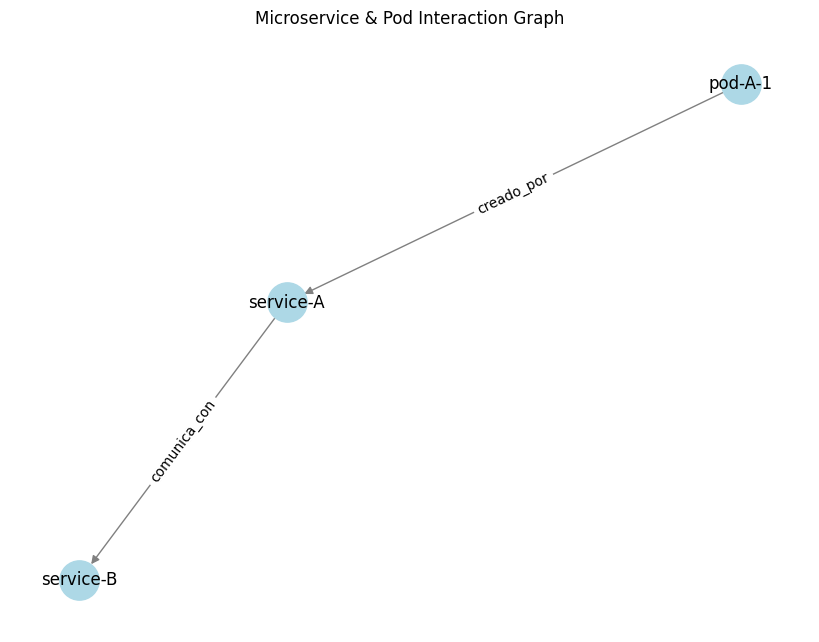

In [43]:
import networkx as nx

g = nx.DiGraph()

# Definir un timestamp válido (ej. usar el existente timestamp_fallo):
ts = timestamp_fallo

# Insertar un microservicio
g.add_node(
    "service-A",
    timestamp=ts,
    node_type="Microservice",
    properties={"label": "normal"}
)

# Insertar un pod que lo ejecuta
g.add_node(
    "pod-A-1",
    timestamp=ts,
    node_type="Pod"
)
g.add_edge(
    "pod-A-1",
    "service-A",
    edge_type="creado_por",
    timestamp=ts
)

# Insertar comunicación entre microservicios
g.add_node(
    "service-B",
    timestamp=ts,
    node_type="Microservice"
)
g = nx.DiGraph()

# Definir un timestamp válido (ej. usar el existente timestamp_fallo):
ts = timestamp_fallo

# Insertar un microservicio
g.add_node(
    "service-A",
    timestamp=ts,
    node_type="Microservice",
    properties={"label": "normal"}
)

# Insertar un pod que lo ejecuta
g.add_node(
    "pod-A-1",
    timestamp=ts,
    node_type="Pod"
)
g.add_edge(
    "pod-A-1",
    "service-A",
    edge_type="creado_por",
    timestamp=ts
)

# Insertar comunicación entre microservicios
g.add_node(
    "service-B",
    timestamp=ts,
    node_type="Microservice"
)
g.add_edge(
    "service-A",
    "service-B",
    edge_type="comunica_con",
    timestamp=ts,
    properties={
        "latency": 25.4,
        "request_rate": 15,
        "label": "anomalous"
    }
)

# Dibujar el grafo
plt.figure(figsize=(8,6))
pos = nx.spring_layout(g, seed=42)
nx.draw(g, pos,
        with_labels=True,
        node_color='lightblue',
        edge_color='gray',
        node_size=800,
        arrowsize=12)
edge_labels = nx.get_edge_attributes(g, 'edge_type')
nx.draw_networkx_edge_labels(g, pos, edge_labels=edge_labels)
plt.title("Microservice & Pod Interaction Graph")
plt.axis('off')
plt.show()
